In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Custom Data Type

In [2]:
# Value object
class Value:
     
    def __init__(self, data, _children=(), _op='', label=''):
          self.data = data
          self.grad = 0.0
          self._prev = set(_children)
          self._op = _op
          self.label = label
          self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
          other = other if isinstance(other, Value) else Value(other)
          out = Value(self.data + other.data, (self, other), '+')

          def _backward():
             self.grad += 1 * out.grad
             other.grad += 1 * out.grad

          out._backward = _backward
          
          return out
    
    def __radd__(self, other): # other + self
                  return self + other
    
    def __mul__(self, other):
          other = other if isinstance(other, Value) else Value(other)
          out = Value(self.data*other.data, (self, other), '*')
          
          def _backward():
             self.grad += other.data * out.grad
             other.grad += self.data * out.grad
          
          out._backward = _backward

          return out
    
    def __pow__(self,other):
          assert isinstance(other, (int, float))
          out = Value(self.data**other, (self,), f'**{other}')

          def _backward():
                self.grad += (other * (self.data**(other-1))) * out.grad

          out._backward = _backward

          return out
    
    
    def __rmul__(self, other): # other * self
              return self * other
    
    def __truediv__(self, other):
          return self * (other**-1)
    
    def __sub__(self, other):
          return self + (-1.0)*(other)
    
    def tanh(self):
         x = self.data
         t =  (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
         out = Value(t, (self,), 'tanh')

         def _backward():
            self.grad += (1 - t**2) * out.grad
          
         out._backward = _backward

         return out
    
    def exp(self):
          out = Value(math.exp(self.data), (self,), 'exp')

          def _backward():
                self.grad += math.exp(self.data) * out.grad

          out._backward = _backward
          return out


    def backward(self):
      topo = []
      visited = set()
      def build_topo(v):
            if v not in visited:
                  visited.add(v)
                  for child in v._prev:
                        build_topo(child)
                  topo.append(v)
      build_topo(self)
      self.grad = 1.0
      for node in reversed(topo):
            node._backward()


### To Visualize the tree structure in NN

In [17]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir':'LR'}) # TB top to bottom, LR left to right
    nodes, edges = trace(root)

    # drawing the nodes
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    # drawing the edges
    for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)    
    
    return dot

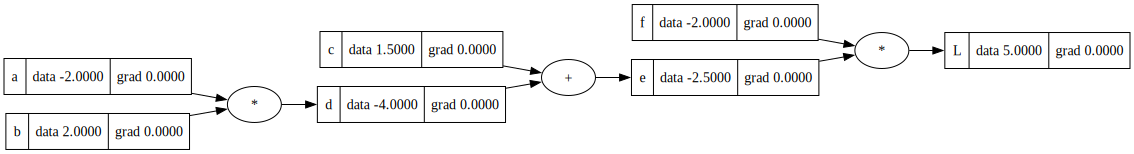

In [13]:
draw_dot(L)

### Building a Neural Network

In [28]:
class Neuron:

    def __init__(self, nin):
      self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
      self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
    # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [29]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        return [n(x) for n in self.neurons]
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


In [30]:
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [36]:
## Tiny dataset
xs = [[2.0, -3.0, 10.0], 
      [4.0, 2.0, -1.0], 
      [5.0, -3.0, 4.0], 
      [-10.0, 7.0, 1.0]]

ys = [1.0, -1.0, -1.0, 1.0] # binary classification

In [95]:
# Automating the process
nn = MLP(3, [4, 4, 1])

# hyperparameters
training_rounds = 100
lr = 0.1

# training loop
for k in range(training_rounds):
    # forward pass
    y_pred = [nn(x) for x in xs]
    loss = sum([(yout[0] - ygt)**2 for ygt, yout in zip(ys, y_pred)])
    
    # reset gradients
    for p in nn.parameters():
        p.grad = 0.0

    # backpropagation
    loss.backward()

    # Gradient Descent
    for p in nn.parameters():
        p.data += -lr * p.grad

    print(k+1, loss)

1 Value(data=1.4244458464189909)
2 Value(data=0.4674294683828961)
3 Value(data=0.152527131517035)
4 Value(data=0.10771684962850944)
5 Value(data=0.08342629129296547)
6 Value(data=0.06787493288872981)
7 Value(data=0.05702607161030415)
8 Value(data=0.04902189832141306)
9 Value(data=0.042874541992926486)
10 Value(data=0.03800705656759164)
11 Value(data=0.03405906640295467)
12 Value(data=0.030793699704687698)
13 Value(data=0.028048885068802723)
14 Value(data=0.025710071559618776)
15 Value(data=0.02369409759580113)
16 Value(data=0.021939216765666278)
17 Value(data=0.020398692816831654)
18 Value(data=0.019036549491746723)
19 Value(data=0.017824667844358693)
20 Value(data=0.016740753393593547)
21 Value(data=0.01576688207533612)
22 Value(data=0.014888443025500648)
23 Value(data=0.014093361397182215)
24 Value(data=0.013371523823712324)
25 Value(data=0.012714353147815691)
26 Value(data=0.012114493906077602)
27 Value(data=0.011565579684921463)
28 Value(data=0.011062060217661518)
29 Value(data=0.0

In [96]:
ys, y_pred

([1.0, -1.0, -1.0, 1.0],
 [[Value(data=0.9685834375826111)],
  [Value(data=-0.9740902067363301)],
  [Value(data=-0.9733188558971981)],
  [Value(data=0.9826888497887014)]])